In [2]:
import io
import os 
import warnings
import sys
import boto3
import findspark
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
findspark.init("/home/ubuntu/spark-3.1.2-bin-hadoop3.2")


from pyspark import SparkContext, Row, SparkConf
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql import SparkSession
from pyspark.sql.functions import (split, 
                                   size,
                                   col,
                                   input_file_name,
                                   udf,
                                   pandas_udf,
                                   PandasUDFType,
                                  )
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

2022-04-22 11:43:17.186733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 11:43:17.186772: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable
print('PYSPARK_PYTHON ', os.environ['PYSPARK_PYTHON'])

PYSPARK_PYTHON  /home/ubuntu/anaconda3/bin/python


In [4]:
os.environ['PYSPARK_DRIVER_PYTHON'] ='/home/ubuntu/anaconda3/bin/python'

In [5]:
# lecture du fichier config.cfg contenant la paire de clées de admin user (IAM)
from configparser import ConfigParser
config = ConfigParser()
config.read('config.cfg')

['config.cfg']

In [6]:
# sauvegarder la paire de clées
key_id = config['whatever']['key']
secret_key = config['whatever']['secret']

In [7]:
os.environ["AWS_ACCESS_KEY_ID"]=key_id
os.environ["AWS_SECRET_ACCESS_KEY"]= secret_key

## 1. Démarrer la session spark

In [8]:
spark  = SparkSession.builder \
                    .appName("P8") \
                    .config('spark.hadoop.fs.s3a.access.key', key_id)\
                    .config('spark.hadoop.fs.s3a.secret.key', secret_key)\
                    .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')\
                    .getOrCreate()

sc = spark.sparkContext

sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")
sc.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")

22/04/22 11:43:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [9]:
spark

## 2. Chargement des données

In [10]:
NAME_BUCKET = 'datasamplep8'
s3_url = f's3a://{NAME_BUCKET}/dataSample/*'
data= (spark.read.format('binaryFile')
       .option("pathGlobFilter", "*.jpg")
       .option("recursiveFileLookup", "true")
       .load(s3_url))
collect = data.select('content').collect()
data = data.drop("modificationTime", "length")
data = data.withColumn('label', split(data.path, '/').getItem(4))
data.show(truncate=20)

22/04/22 11:43:23 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


+--------------------+--------------------+--------+
|                path|             content|   label|
+--------------------+--------------------+--------+
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Apricot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Apricot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Apricot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Apricot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Apricot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Apricot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Avocado|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Avocado|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Avocado|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Avocado|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Avocado|
|s3a://datasamplep...|[FF D8 FF E0 00 1...| Avocado|
|s3a://datasamplep...|[FF D8 FF E0 00 1...|Beetroot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...|Beetroot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...|Beetroot|
|s3a://datasamplep...|[FF D8 FF E0 00 1...|Bee

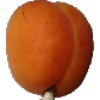

In [17]:
# affichage d'une image 

first_img = collect[1][0]
image_1 =Image.open(io.BytesIO(first_img))
image_1.show()

## Préparation du modèle 

In [33]:
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
model.summary() 

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [34]:
# créer le modèle de transfer learning ResNet50
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights='imagenet', pooling='avg', include_top=False)
    model.set_weights(bc_model_weights.value)
    return model


## Prétraitement des images

In [26]:
# fonction qui permet de prétraiter une image (ouvrir, redimensionner et la praittraiter selon le format/
#acceptable par ResNet50

def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)) 
    arr = img_to_array(img) 
    return preprocess_input(arr)

## Extraction des features

In [36]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input) # Prédiction grâce au modèle RestNet50 
    output = [p.flatten() for p in preds] # Aplatissement de la sortie avec la fonction faltten()
    return pd.Series(output) 

 This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
 
 With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.

In [35]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/ubuntu/spark-3.1.2-bin-hadoop3.2/python/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [29]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [37]:
# création d'UDF qui transforme chaque ligne vers un vecteur
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [38]:
# appliquer "featurize_udf" sur tout le dataframe
features_df = data.repartition(16).select(col('path'), featurize_udf('content').alias('features'))
# appliquer "list_to_vector_udf" sur tout le dataframe
features_df = features_df.withColumn("features_udf", list_to_vector_udf(col("features")))

In [39]:
features_df.show()

2022-04-22 12:25:57.321788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 12:25:57.321834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 12:26:43.290867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-22 12:26:43.290910: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-22 12:26:43.290942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-242): /proc/driver/nvidia/version does not exist
2022-04-22 12:26:43.291679: I tensorflow/core/platform/cpu_f

+--------------------+--------------------+--------------------+
|                path|            features|        features_udf|
+--------------------+--------------------+--------------------+
|s3a://datasamplep...|[2.7744932, 0.207...|[2.77449321746826...|
|s3a://datasamplep...|[1.3898871, 0.597...|[1.38988709449768...|
|s3a://datasamplep...|[1.2606585, 1.103...|[1.26065850257873...|
|s3a://datasamplep...|[0.0, 0.8926905, ...|[0.0,0.8926904797...|
|s3a://datasamplep...|[1.0836365, 0.401...|[1.08363652229309...|
|s3a://datasamplep...|[1.3608699, 1.228...|[1.36086988449096...|
|s3a://datasamplep...|[2.1717293, 1.090...|[2.17172932624816...|
|s3a://datasamplep...|[0.013492599, 0.8...|[0.01349259912967...|
|s3a://datasamplep...|[1.6253326, 0.805...|[1.62533259391784...|
|s3a://datasamplep...|[0.0, 1.2141001, ...|[0.0,1.2141001224...|
|s3a://datasamplep...|[2.7273912, 0.872...|[2.72739124298095...|
|s3a://datasamplep...|[0.010220133, 0.9...|[0.01022013276815...|
|s3a://datasamplep...|[1.

In [43]:
# extraire nombre de features
print("le nombre de features initial est:", len(features_df.collect()[1][2]))

2022-04-22 12:36:07.494434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 12:36:07.494944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 12:36:09.787170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-22 12:36:09.787611: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-22 12:36:09.787805: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-242): /proc/driver/nvidia/version does not exist
2022-04-22 12:36:09.788213: I tensorflow/core/platform/cpu_f

le nombre de features initial est: 2048


## Réduction de dimension : PCA

In [44]:
# standardisation des features

scaler = StandardScaler(
    inputCol="features_udf", 
    outputCol="features_scaled")

data_scaled = scaler.fit(features_df).transform(features_df)

2022-04-22 12:44:46.296937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 12:44:46.297188: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 12:44:46.297989: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 12:44:46.298176: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 12:44:48.393831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022

In [45]:
data_scaled.show()

2022-04-22 12:46:08.071114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 12:46:08.071634: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 12:46:10.296679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-22 12:46:10.296773: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-22 12:46:10.296817: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-242): /proc/driver/nvidia/version does not exist
2022-04-22 12:46:10.297048: I tensorflow/core/platform/cpu_f

+--------------------+--------------------+--------------------+--------------------+
|                path|            features|        features_udf|     features_scaled|
+--------------------+--------------------+--------------------+--------------------+
|s3a://datasamplep...|[2.7744932, 0.207...|[2.77449321746826...|[3.15715911287916...|
|s3a://datasamplep...|[1.3898871, 0.597...|[1.38988709449768...|[1.58158422541420...|
|s3a://datasamplep...|[1.2606585, 1.103...|[1.26065850257873...|[1.43453206322015...|
|s3a://datasamplep...|[0.0, 0.8926905, ...|[0.0,0.8926904797...|[0.0,2.7849302179...|
|s3a://datasamplep...|[1.0836365, 0.401...|[1.08363652229309...|[1.23309471433063...|
|s3a://datasamplep...|[1.3608699, 1.228...|[1.36086988449096...|[1.54856488032219...|
|s3a://datasamplep...|[2.1717293, 1.090...|[2.17172932624816...|[2.47126033320345...|
|s3a://datasamplep...|[0.013492599, 0.8...|[0.01349259912967...|[0.01535353628925...|
|s3a://datasamplep...|[1.6253326, 0.805...|[1.62533259

#### Nous allons entrainer le modèle PCA avec 150 composantes, ensuite le fitter sur notre dataframe

In [72]:
#entrainement de l'algorithme PCA
pca = PCA(k=1000, inputCol="features_scaled", outputCol="features_reduced")
model_pca = pca.fit(data_scaled)
data_final = model_pca.transform(data_scaled)

2022-04-22 13:30:40.405735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 13:30:40.405773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 13:30:42.506077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-22 13:30:42.506115: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-22 13:30:42.506141: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-242): /proc/driver/nvidia/version does not exist
2022-04-22 13:30:42.506365: I tensorflow/core/platform/cpu_f

La variance expliquée égale a 99% est vérifiée avec 19 composantes


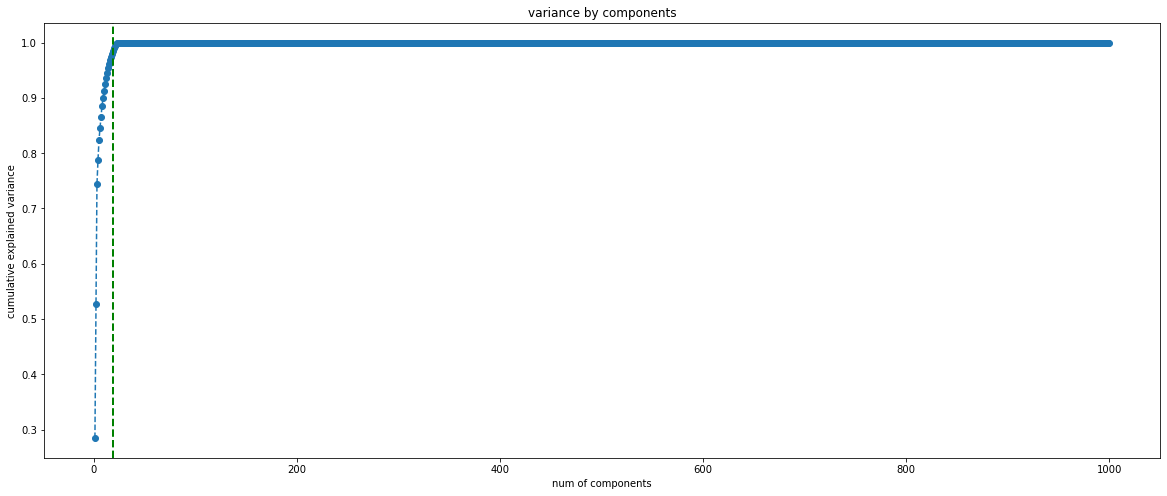

In [76]:
# Calcul de la variance expliquée cumulée par les composantes
cumValues = model_pca.explainedVariance.cumsum() # get the cumulative values

# fixer le seuil de variance expliqué minimal
seuil = 99

# afficher le graphe pour décider du nombre de composantes à considérer
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(range(1,1001), cumValues, marker = 'o', linestyle='--')

X_idx = np.where(cumValues*100 >= seuil)[0]
nb_composante = X_idx[cumValues[X_idx].argmin()]
plt.axvline(x=nb_composante, linestyle="--", color="green",linewidth=2)

plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')


print(f"La variance expliquée égale a {seuil}% est vérifiée avec {nb_composante} composantes")

## Sauvegarde des feature dans S3 Bucket

In [77]:
data_final = data_final.select(col('path'), col('features_reduced'))

In [78]:
data_final.show()

22/04/22 13:36:03 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
2022-04-22 13:36:04.194613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 13:36:04.194652: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 13:36:06.305598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-22 13:36:06.305638: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-22 13:36:06.305671: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-242): /proc/driver/nvi

+--------------------+--------------------+
|                path|    features_reduced|
+--------------------+--------------------+
|s3a://datasamplep...|[-2.8742169888503...|
|s3a://datasamplep...|[-19.805849201691...|
|s3a://datasamplep...|[-0.8493830764968...|
|s3a://datasamplep...|[44.3625338815324...|
|s3a://datasamplep...|[-1.5824096402623...|
|s3a://datasamplep...|[-25.233850321742...|
|s3a://datasamplep...|[-1.4485307328069...|
|s3a://datasamplep...|[44.5598748299897...|
|s3a://datasamplep...|[-1.1811121985679...|
|s3a://datasamplep...|[43.4775539991654...|
|s3a://datasamplep...|[-1.7379968183007...|
|s3a://datasamplep...|[42.0991649085843...|
|s3a://datasamplep...|[-1.0134109029891...|
|s3a://datasamplep...|[45.8768556694183...|
|s3a://datasamplep...|[-1.8853898962059...|
|s3a://datasamplep...|[43.0120985549507...|
|s3a://datasamplep...|[-2.5583185442541...|
|s3a://datasamplep...|[-19.419887515540...|
|s3a://datasamplep...|[-2.2500428159827...|
|s3a://datasamplep...|[-14.22795

In [79]:
data_final.write.parquet("s3a://datasamplep8/extractedFeatures.parquet")

22/04/22 13:42:42 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB
2022-04-22 13:42:43.312068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 13:42:43.312604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 13:42:43.359856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 13:42:43.359893: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 13:42:45.759243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'